### This notebook allows Glen's A to vary to optimize modeled ice thickness by minimizing the quadratic error between observed and modeled ice thickness (following height change corrections and in situ mass balance inversion)

### Applies a k-folding cross validation method

## Imports

In [1]:
%matplotlib inline
import numpy as np
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
from oggm import utils, workflow, tasks, graphics

import os
import pandas as pd
import salem
import xarray as xr
import oggm
from oggm.workflow import execute_entity_task, gis_prepro_tasks, climate_tasks

import oggm.cfg as cfg # could that cause problems?

from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
import gdal
from PIL import Image as imagery
import datetime

## Select the glacier by setting num to:

- 0 for Kokanee
- 1 for Haig
- 2 for Conrad
- 3 for W. Washmawapta (no DEM correction available)
- 4 for Illecillewaet (not supported in this version of the script due to shapefile reasons)
- 5 for Nordic (not supported in this version of the script due to shapefile reasons)
- 6 for Zillmer


In [2]:
# Here the num variable is set:
num=2
errors_list = []
# A list with all the glacier names
glacier = ['Kokanee', 'Haig', 'Conrad', 'Washmawapta', 'Illecillewaet', 'Nordic', 'Zillmer']
glacier_lower = ['kokanee', 'haig', 'conrad', 'washmawapta', 'illecillewaet', 'nordic', 'zillmer']
obs_num = [442,387,824,187,820,461,483] #number of grid cells with obs
thick = [48.1, 115.4, 99.7, 69.3, 101.4, 47.6, 67.5]

# Just confirm that the correct one is selected for this run of the script
print('You selected: ' , glacier[num])

You selected:  Conrad


### File names settings

In [3]:
# list with the names in the Randolf Glacier invetory (according to the glacier names above)
rgi_list = ['RGI60-02.00147', 'RGI60-02.01857', 'RGI60-02.02171', 'RGI60-02.03688', 'RGI60-02.04264', 'RGI60-02.07780']

# list with the names Lidar data (according to the glacier names above)
dem = ['kokanee/20160913_kokanee_dem1_clip_slave.tif', 'haig/20150912_haig_dem_master_clip.tif', 'conrad/20160912_conrad_dem1_clip_slave.tif', 'not_assigned', 
       'illecillewaet/170917_illecillewaet_dem1_clip_slave.tif', 'nordic/20170927_nordic_dem1_clip_slave.tif', 'zillmer/160914_zillmer_dem2.tif']

#products_directory (where the graphs and some numbers are saved for later usage)
products= '/home/pelto/oggm_runs/products_opt/' + glacier[num] + '/'

# moved best value here to avoid iterating over multiple glen's A values 
# best_value = 6.740e-24, 0.774e-24, 8.095e-24, 0.142e-24, 4.050e-24, 13.0e-24, 3.810e-24  
best_value = 4.84e-24, 0.596e-24, 7.381e-24, 0.142e-24, 4.544e-24, 14.627e-24, 3.432e-24
best_value = best_value[num]
# best_value = 5.08e-24  #2.4e-24

count=0
sw = 251.
DFB = 0.25 ##np.arange(0.0, 1.0, 0.05) # the exponent of the distance from border mask default=0.25

## A function to run the OGGM using mass-balance correction and (if wished) the Lidar-DEM 

This is also a function that runs the OGGM on the selected glacier and returns a thickness map for it. It uses the mass-balance correction.

In difference to the function above, this version does not use the SRTM DEM to run it but the more precise Lidar DEM which yields results closer to reality.


In [4]:
def new_mb_grad_corr_dem(num, dem, glacier, name, parameter, best, use_dem_corr):
    """
    :param num: number of selected glacier
    :param dem: list with dem file names
    :param glacier: the list with the glacier names
    :param name: name of the parameter to be modified
    :param parameter: value of the parameter to be modified
    :param best: if TRUE, an extra save with prefix 'best' will be created
    :param use_dem_correction: if TRUE, a Lidar DEM correction will be used
    :type num: int
    :type dem: str list
    :type glacier: str list
    :type name: str 
    :type parameter: float
    :type best: boolean
    :type use_dem_correction: boolean
    :returns: distributed thickness
    :rtype: 2D float array
    """
    # Initialize OGGM and set up the run parameters --> Read the configuration file containing the run’s parameters.
    cfg.initialize(logging_level='WORKFLOW')

    #num determines which gdir and gradient to use, refer to list below to select desired site
    grad = [6.84, 9.8, 7.11, 7.95, 10.84, 6.01, 7.92] # mm w.e. m-1
    
    # Get the RGI glaciers for the run.
    rgi_list = ['RGI60-02.00147', 'RGI60-02.01857', 'RGI60-02.02171', 'RGI60-02.03411', 'RGI60-02.03688', 'RGI60-02.04264', 'RGI60-02.07780']
        
    custom_dem_path = '/home/pelto/Desktop/lidar_cbt_analysis/' + dem[num] #glacier_lower[num]
    print(custom_dem_path)
    WORKING_DIR = utils.gettempdir(glacier[num] + '_SR_lidar_dem') # Let's make a working directory for this DEM 
    utils.mkdir(WORKING_DIR, reset=True)
    cfg.PATHS['working_dir'] = WORKING_DIR
    cfg.PARAMS[name] = parameter
    cfg.PARAMS['border'] = 10
    rgidf = utils.get_rgi_glacier_entities([rgi_list[num]])
      
    if(use_dem_corr==True):
        
        cfg.PATHS['dem_file'] = custom_dem_path
        rgidf['DEM_SOURCE'] = 'USER'
        
        cfg.PARAMS['smooth_window'] = sw
        if glacier[num] == 'Nordic' or 'Washmawapta':
            cfg.PARAMS['use_intersects'] = False
        else:
            cfg.PARAMS['use_intersects'] = True

    else:
        cfg.PARAMS['use_intersects'] = True
        if glacier[num] == 'Nordic' or 'Washmawapta':
            cfg.PARAMS['use_intersects'] = False
        cfg.PARAMS['border'] = 10
        cfg.PATHS['working_dir'] = utils.get_temp_dir('_SR_thick_srtm' + glacier[num])
        cfg.PARAMS[name] = parameter
        cfg.PARAMS['smooth_window'] = sw
        
    gdirs = workflow.init_glacier_directories(rgidf) #,from_prepro_level=1, prepro_border=10) 
    workflow.execute_entity_task(tasks.define_glacier_region, gdirs)
#     gdirs = workflow.init_glacier_regions(rgidf)
    workflow.gis_prepro_tasks(gdirs)
    workflow.climate_tasks(gdirs)           # runs all climate related tasks
   
     # Let's apply a linear MB instead
    from oggm.core.climate import apparent_mb_from_linear_mb
    from oggm.core.massbalance import LinearMassBalance, MultipleFlowlineMassBalance, ConstantMassBalance
    gdir = gdirs[0]
    mb_mod = MultipleFlowlineMassBalance(gdir, use_inversion_flowlines=True, mb_model_class=ConstantMassBalance)
    z, w, mb_on_z = mb_mod.get_annual_mb_on_flowlines()
    mb_on_z *=  cfg.PARAMS['ice_density'] * cfg.SEC_IN_YEAR
#     grad = 6.43 #6.43 mm w.e. m-1 from all glaciological point data for basin run
    workflow.execute_entity_task(tasks.apparent_mb_from_linear_mb, gdir, mb_gradient=grad[num]);
    params = gdir.read_pickle('linear_mb_params')
   
    #max_mb Cap the mass balance to a certain value (unit: [mm w.e. yr-1], we use 2000 mm w.e.
    l_mb_mod = LinearMassBalance(params['ela_h'], grad=params['grad'], max_mb=2000.)
    l_mb_on_z = l_mb_mod.get_annual_mb(z) * cfg.PARAMS['ice_density'] * cfg.SEC_IN_YEAR

    # See the result of the inversion
    workflow.inversion_tasks(gdirs)
    workflow.execute_entity_task(tasks.distribute_thickness_per_altitude, gdirs, dis_from_border_exp=DFB);
    
    tasks.init_present_time_glacier(gdir) ##This updates the mode_flowlines file and creates a stand-alone numerical glacier ready to run.

    ds_new = xr.open_dataset(gdir.get_filepath('gridded_data')).load()
    ds_new.close() 

    ########### gather more detailed information about the glacier ##############
    df  = utils.compile_glacier_statistics(gdirs, inversion_only=True)
    volume=df['inv_volume_km3']

    mfl=gdir.read_pickle('model_flowlines')
    thickness= mfl[-1].surface_h - mfl[-1].bed_h
    thickness=thickness[thickness>0].mean()

    ############## write it into txt file: #################

    if(best):
        file= open(products+'best_dem_corr_run_of_'+glacier[num]+'_with_modified_' + name + '.txt', mode='w')
        print('parameter value: '+str(parameter)+'\n')
        print('glacier total volume: '+str(volume)+' km^3 \n \n \n')
        print('mean thickness value: '+str(thickness)+' m \n')
    else:
        file= open(products+'dem_corr_run_of_'+glacier[num]+'_with_modified_' + name+'.txt', mode='w')

    file.writelines(['Run of the DEM corrected model on ' + glacier[num]+' on ', str(datetime.datetime.now()), '\n'])
    file.write('parameter modified: '+name+'\n')
    file.write('parameter value: '+str(parameter)+'\n')
    file.write('glacier total volume: '+str(volume)+' km^3 \n \n \n')
    file.write('mean thickness value: '+str(thickness)+' m \n')
#     file.write('Minimal value is '+str(np.min(to_plot[1]))+ ' at ' + parameter_name+' = ' +str(np.round(to_plot[0][x],decimals=28)))
    file.close()
    ##########################################################
    print(gdir)
#     if best==True:
#         return ds_new
#     else:
    return ds_new

# run the model with DEM correction
new_mb_gradient_corr_dem = new_mb_grad_corr_dem(num, dem, glacier, 'ice_density', 900, False, True)
###############################################(num, dem, glacier, name, parameter, best, use_dem_corr):

# plot it as a map
# new_mb_gradient_corr_dem.plot()
# plt.title(glacier[num]+' DEM corrected Thickness map')
# and save it
# plt.savefig(products+'dem_corr_standard_map_'+ glacier[num]+'.png', dpi=100)

# replace 'nan' by  0
new_mb_gradient_corr_dem=new_mb_gradient_corr_dem.distributed_thickness.fillna(0)

2020-04-28 19:25:16: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_pub/lib/python3.7/site-packages/oggm/params.cfg
2020-04-28 19:25:16: oggm.cfg: Multiprocessing switched ON according to the parameter file.
2020-04-28 19:25:16: oggm.cfg: Multiprocessing: using all available processors (N=8)
2020-04-28 19:25:22: oggm.cfg: PARAMS['border'] changed from `20` to `10`.


/home/pelto/Desktop/lidar_cbt_analysis/conrad/20160912_conrad_dem1_clip_slave.tif


2020-04-28 19:25:23: oggm.cfg: PARAMS['use_intersects'] changed from `True` to `False`.
2020-04-28 19:25:23: oggm.workflow: Execute entity task define_glacier_region on 1 glaciers
2020-04-28 19:25:26: oggm.workflow: Execute entity task define_glacier_region on 1 glaciers
2020-04-28 19:25:28: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
/home/pelto/anaconda2/envs/oggm_pub/lib/python3.7/site-packages/oggm/core/gis.py:478: RuntimeWarning: invalid value encountered in less_equal
  topo[topo <= -999.] = np.NaN
2020-04-28 19:25:29: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2020-04-28 19:25:29: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2020-04-28 19:25:29: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2020-04-28 19:25:29: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2020-04-28 19:25:29: oggm.workflow: Execute entity task catchment_area on 1 glaciers
2020-04-28 19

<oggm.GlacierDirectory>
  RGI id: RGI60-02.02171
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 16.898 km2
  Lon, Lat: (-116.93, 50.8069)
  Grid (nx, ny): (106, 125)
  Grid (dx, dy): (68.0, -68.0)



In [5]:
## Parameter optimization

#     We want to run the Model with different values for a certain parameter. Therefore we define a few functions that will iterate over a sequenze of paramter values and allow us to compare the outcome to the observation data by displaying their respective squared residuals

def run_with_parameter(num,dem, glacier, name, parameter):
    """
    :param num: number of selected glacier
    :param dem: list with dem file names
    :param glacier: the list with the glacier names
    :param name: name of the parameter to be modified
    :param parameter: value of the parameter to be modified
    :type num: int
    :type dem: str list
    :type glacier: str list
    :type name: str 
    :type parameter: float
    :returns: distributed thickness
    :rtype: 2D float array
    """

    # just to be 100% sure, we are setting the most common parameters to their presettings in order to only vary the desired parameter
    cfg.PARAMS['smooth_window'] = sw
    cfg.PARAMS['ice_density'] = 900
    cfg.PARAMS['trapezoid_lambdas'] = 0.2
    cfg.PARAMS['mixed_min_shape'] = 0.001
    cfg.PARAMS['downstream_min_shape'] = 0.0001
    cfg.PARAMS['mu_star_halfperiod'] = 15
    cfg.PARAMS['tstar_search_glacierwide'] = False
    cfg.PARAMS['border'] = 10
    cfg.PARAMS['glen_a'] = 2.4e-24
    cfg.PARAMS['inversion_glen_a'] = 2.4e-24
    cfg.PARAMS['default_parabolic_bedshape'] = 0.003
    cfg.PARAMS['use_shape_factor_for_fluxbasedmodel'] = ''

    #change the parameter (not sure, whether it has any effect here...)
    cfg.PARAMS[name] = parameter

    # run the model (in this case with DEM correction)
    outcome=new_mb_grad_corr_dem(num, dem, glacier, name, parameter, False, True).fillna(0)

    #return the thickness distribution
    return outcome

## Definitions


# deletes the rows and lines that do only carry zeros for the sake of getting the right resolution 
# in order to rasterize the observation data to the same resolution and getting perfectly fitting arrays
def delete_nodata(data):
    """
    :param data: distributed thickness with 'nan' or '0' in it
    :type data: 2D floar array
    :returns: distributed thickness
    :rtype: 2D float array
    """

    # get a numpy array out of it
    data=data.values

    #get the spots were actual values are
    coordinates=np.nonzero(data)

    # create a fresh array of the minimal shape to contain all non-zero values
    result=np.zeros(((1+np.max(coordinates[0])-np.min(coordinates[0])) ,(1+np.max(coordinates[1])-np.min(coordinates[1]))))

    # fill it with the values
    for i in range(0, len(coordinates[0])):
        result[coordinates[0][i]-np.min(coordinates[0])][coordinates[1][i]-np.min(coordinates[1])]=data[coordinates[0][i]][coordinates[1][i]]

    # flip it and rotate it by pi
    return np.flip(np.rot90(result,2))

# a simple function to open the observation data and return it as an array
def read_obs_data(path):
    """
    :param path: distributed thickness with 'nan' or '0' in it
    :type path: str
    :returns: measurement points as an array
    :rtype: 2D float array
    """
    src_obs = gdal.Open(path)
    return src_obs.ReadAsArray()

## Data Import

# We open the observation data for the respective glacier and print out the shape and compare it with the shape of the OGGM:
## IPR data (ice penetrating radar data)

obs_data = read_obs_data('/home/pelto/oggm_runs/OGGM/MONSTER_project/MONSTER/obs_data_' + glacier[num] + '.tif')

if obs_data.shape == delete_nodata(new_mb_gradient_corr_dem).shape:
    print('Fantanstic, both arrays have the same shape of: ' ,obs_data.shape )
else:
    print('Oh, Oh! Something went wrong because the observation data has the shape ' ,obs_data.shape , ' and the OGGM out put has a shape of: ' ,delete_nodata(new_mb_gradient_corr_dem).shape )


# Layover-Control

#     This is a checking tool for adjusting the orientation of the observation data with respect to the model shapefile (in order to make it fit, we had to flip and rotate it in the 'delete_nodata' function). The resolution is not great but is should give an optical feedback on the fit. 

# run the delete_nodata function on one of the recent outputs and save it in a temporay variable
temp=delete_nodata(new_mb_gradient_corr_dem)

# get its shape
h,w = temp.shape

# create a new array with zeros and of same size
data = np.zeros((h, w, 3), dtype=np.uint8)

# and get the data point coordinates
nonzero=np.nonzero(temp)

# run through the OGGM output and write into the array as RED color code
for i in range(0,len(nonzero[0])):
    data[nonzero[0][i]][nonzero[1][i]]= [temp[nonzero[0][i]][nonzero[1][i]], 0, 0]

# run through the observation data and write into the array as GREEN color code
for i in range(0,len(np.nonzero(obs_data)[0])):
    data[np.nonzero(obs_data)[0][i]][np.nonzero(obs_data)[1][i]]= [0, obs_data[np.nonzero(obs_data)[0][i]][np.nonzero(obs_data)[1][i]], 0]

# # save and show
# img = imagery.fromarray(data, 'RGB')
# img.save(products+ 'overlay_test_'+ glacier[num]+ '.png')

# from IPython.display import Image
# Image(filename=products+'overlay_test_'+ glacier[num]+ '.png', width=400) 

def quadratic_errors(obs_data, TRAIN, TEST, mesharray):  #,TRAIN=None):
    """
    :param obs_data: array with measured values on respective spots
    :param mesharray: distributed thickness of the model output (should have same shape as obs_data)
    :type obs_data: 2D float array
    :type mesharray: 2D float array
    :returns: quadrativc error (problems corrected)
    :rtype: float
    """
    
    # counts number of "problematic" pixels
    count=0
    problems=0 # accumulated 'problematic pixel' quadratic error
    prob=0 #problems per grid cell summed
    err=0 # total accumulated quadratic error
    ME=0;  MAE=0; MEp=0; MAEp=0
    
##### Calibration sample (50%) ####
    # we go through all the measured points and accumulate the squared differences to the OGGM at that point
#     if TRAIN is not None:
    for i in TRAIN:

        x_coord=all_coords[0][i]
        y_coord=all_coords[1][i]
        
        OBS=obs_data[x_coord][y_coord]
        MODEL=mesharray[x_coord][y_coord]
        
        # if however, the OGGM shows a thickness of zero there, this seems to be a "problematic" pixel 
        if MODEL==0:

            # add to problems share
            problems=problems+OBS**2
            prob=(prob+OBS)

            # increment problem number
            count=count+1

        # add squared difference
#         err=err+(OBS-MODEL)**2
        ##add mean error and mean absolute error
#         ME_arr = OBS-MODEL
        ME=ME+(OBS-MODEL)
        MEp=MEp+((OBS-MODEL)/(OBS))
        MAE=MAE+np.abs(OBS-MODEL)
        MAEp=MAEp+np.abs((OBS-MODEL)/(OBS))

##### Validation (--thus the 'V' appended) sample (50%) ####
    errV=0; problemsV=0; probV=0; MAEV=0; MAEVp=0; MEV=0; MEVp=0; MEV_all=[]
    for t in TEST:
        x_coord=all_coords[0][t]
        y_coord=all_coords[1][t]
        
        OBS=obs_data[x_coord][y_coord]
        MODEL=mesharray[x_coord][y_coord]
        
        if MODEL==0:
#             add to problems share
            problemsV=problemsV+OBS**2
            probV=probV+OBS
#             # increment problem number
#             count=count+1
        
#         errV=errV+(OBS-MODEL)**2
        ##add mean error and mean absolute error
        MEV_all.append(OBS-MODEL)
        MEV=MEV+(OBS-MODEL)
        MEVp=MEVp+((OBS-MODEL)/(OBS))
        MAEV=MAEV+np.abs(OBS-MODEL)
        MAEVp=MAEVp+np.abs((OBS-MODEL)/(OBS))
        
    # print of details on "problematic" pixels
#     print('found ', count , ' problem(s) within a total number of data point of: ', len(TRAIN), ' problem share ', problems/err,)
    
    ME_final = (ME)/(len(TRAIN))
    MEp_final = (MEp)/(len(TRAIN))
    MAE_final = (MAE)/(len(TRAIN))
    MAEp_final = (MAEp)/(len(TRAIN)) ## percent ME for calibration data
                 
    ME_finalV = (MEV)/(len(TEST))
    MAE_finalV = (MAEV)/(len(TEST))
    MAEp_finalV = (MAEVp)/(len(TEST)) ## percent MAE for validation data
    MEp_finalV = (MEVp)/(len(TEST)) ## percent ME for validation data
    
    problems_per = prob / (len(TRAIN)) ##quite small or zero at all sites, but worth evaluating
    problems_perV = probV / (len(TEST)) ##quite small or zero at all sites, but worth evaluating
    MEV_sd=np.nanstd(MEV_all)
#     print('corrected quadratic error is: ', err-problems)
#     print('ME:', ME_final-problems_per)
#     print('MAE:', MAE_final-problems_per)
#     print('mear', ME_arr)
#     return (err-problems, ME_final-problems_per, MAE_final-problems_per, ME_arr)
#     return (MAE_final-problems_per) ## ---> only export MAE for now

    return (MAE_final-problems_per, MAE_finalV-problems_perV, MAEp_final, MAEp_finalV, ME_final-problems_per, 
            ME_finalV-problems_perV, MEp_final, MEp_finalV, MEV_sd) 

# a function that runs the (DEM-corrected) OGGM and uses the quadratic_errors function to return the quadratic errors
def master_analysis(name, parameter, obs_data, TRAIN, TEST,glacier, num):  #,TRAIN=None):
    """
    :param name: name of the parameter to be modified
    :param parameter: value of the parameter to be modified
    :param obs_data: measured data points
    :param glacier: the list with the glacier names
    :param num: number of selected glacier
    :type name: str
    :type parameter: float
    :type obs_data: 2D float array
    :type glacier: str list
    :type num: int
    :returns: quadratic errors
    :rtype: float
    """
    quadmesh= run_with_parameter(num, dem, glacier, name, parameter)
    mesharray = delete_nodata(quadmesh)
    
    return quadratic_errors(obs_data,TRAIN, TEST, mesharray) #,TRAIN=TRAIN)

# this function takes in the name of the parameter that is to be modified and a float list of the values for whose the OGGM is 
# to be run and the quadratic errors to be calculated. It returns an array with those values and their respective quadratic errors
def optimize(name, values, obs_data,TRAIN, TEST ,glacier, num):  #,TRAIN=None):
    """
    :param name: name of the parameter to be modified
    :param values: values of the parameter to be modified
    :param obs_data: measured data points
    :param glacier: the list with the glacier names
    :param num: number of selected glacier
    :type name: str
    :type values: float list
    :type obs_data: 2D float array
    :type glacier: str list
    :type num: int
    :returns: [values, quad_errors]
    :rtype: float array
    """
    
    # here we store the original parameter value
    temp= cfg.PARAMS[name]
    
    #an array to store the quadratic errors in
    quad_errors=[]
    for i in range(0,len(values)):
        quad_errors.append(master_analysis(name, values[i], obs_data, TRAIN, TEST, glacier, num))  # TRAIN=TRAIN))
        
    # and here we reset it to the default value
    cfg.PARAMS[name] = temp
    
    return [quad_errors] ##return [values, quad_errors]

Fantanstic, both arrays have the same shape of:  (106, 87)


## Enter the parameter, interval and number of points that you want to get the quadratic error from 

The parameter intervall will be a linearly spaced sequence from min_value to max_value with number_of_steps steps.

Also, choose, whether you prefer to run the iteration with the DEM correction. In the most cases it is strongly recommended to do so.

In [6]:
##split data into two groups (based on coordnates where there are GPR data) 
##80% taken for calibration, 20% held for validation

all_coords=np.nonzero(obs_data)
Index_range=np.arange(0,len(all_coords[0]))

Cal, Val= train_test_split(Index_range, test_size=0.2)

In [7]:
parameter_name='inversion_glen_a'
# best_value = 4.84e-24, 0.596e-24, 9.5e-24, 0.142e-24, 4.544e-24, 14.627e-24, 3.55e-24#3.432e-24
best_value = 8.2e-24, 2.98e-24, 10.14e-24, 0.142e-24, 4.544e-24, 14.627e-24, 3.55e-24#3.432e-24 
max_value=best_value[num]+0.2e-24  #0.1e-24
min_value=best_value[num]-0.2e-24  #54e-24
number_of_steps=41

if glacier[num] == "Washmawapta":
    use_dem_correction=False
else:
    use_dem_correction=True

In [ ]:
# best_value=6.37e-24 # if assessing Basin run error
# Creep=np.linspace(best_value-0.01e-24, best_value+0.01e-24, 3) ##for basin run error test
Creep=np.arange(best_value[num]-0.5e-24, best_value[num]+0.5e-24, 0.02e-24)  #np.linspace(min_value, max_value, number_of_steps)
print(len(Creep))
Creep

In [ ]:
calibration=[]

from sklearn.model_selection import KFold
# rkf = RepeatedKFold(n_splits=2, n_repeats=2) 
LOOP=0

# Creep=np.linspace(min_value, max_value, number_of_steps)
start_time=datetime.datetime.now()
# kf = KFold(n_splits=2)
while LOOP<1:
    loop_time=datetime.datetime.now()
    train_index, test_index=train_test_split(Cal, test_size=0.5)
#     print('TRAIN:', train_index, 'TEST:', test_index)
#     x_train = []
#     y_train = []
#     for i in train_index:
#         x_train.append(all_coords[0][i])
#         y_train.append(all_coords[1][i])
    TP=optimize(parameter_name,Creep,obs_data, train_index, test_index, glacier, num)
#     TP=optimize(parameter_name,Creep,obs_data, test_index, glacier, num,TRAIN=train_index)
#     CV = pd.DataFrame(list(zip(TP, Q_in, cr_area, sQout, sQin, Q_outF, Q_inF, sQoutF, sQinF, cr_areaF, vzdir)), 
#             columns=['Q_out', 'Q_in', 'cr_area', 'sQout', 'sQin', 'Q_outF', 'Q_inF','sQoutF', 'sQinF', 'cr_areaF', 'vzdir']) 
    calibration.extend(TP) 
    print('LOOP:',LOOP, 'run time:', datetime.datetime.now()-loop_time)
    LOOP=LOOP+1
print('total time elapsed:', datetime.datetime.now()-start_time)

In [ ]:
calibration

In [ ]:
np.shape(calibration)

In [ ]:
C=[];V=[];Cp=[];Vp=[]
for i in range(np.shape(calibration)[0]):
    CAL1=np.array(calibration[i])
    C.append(CAL1[:,0]) #MAE cal
    V.append(CAL1[:,1]) #MAE val
    Cp.append(CAL1[:,2]) #MAE %cal
    Vp.append(CAL1[:,3]) #MAE %val
C_con=np.concatenate(C);V_con=np.concatenate(V);Cp_con=np.concatenate(Cp);Vp_con=np.concatenate(Vp)

idxC= np.where(C_con==min(C_con))[0][0]
MinERR= V_con[idxC];MinERRcal=C_con[idxC];MinERRp= Vp_con[idxC];MinERRpcal=Cp_con[idxC]

row=np.mod(idxC,len(Creep)) #replaced number_of_steps with len(Creep) since I'm not using number of steps now 

In [ ]:
np.min(C_con)

In [ ]:
print('Val MAE:', MinERR, 'Cal MAE:',MinERRcal,'Val MAE %:', MinERRp, 'Cal MAE %:', MinERRpcal)

In [ ]:
idxC

In [ ]:
Creep

In [ ]:
Creep_best=Creep[row]
print(Creep_best)
Creep_val=np.linspace(Creep_best-0.01e-24, Creep_best+0.01e-24, 3) ##Creep must have more than one value, so we add two values, which will be ignored
Creep_val

In [ ]:
# now we are getting coordinates for the validation dataset to assess model error
# this is the 20% set of IPR data we held back at the start
# x_train_val=[];y_train_val=[]
# for i in Val:
#     x_train_val.append(all_coords[0][i])
#     y_train_val.append(all_coords[1][i])
Validation=[]
    
# Validation=optimize(parameter_name,np.linspace(best_value[num]-0.1e-24, best_value[num]+0.1e-24, 3),obs_data, Val, glacier, num)
V=optimize(parameter_name,Creep_val,obs_data, Val,Val, glacier, num)
Validation.extend(V)

# V[0][1][0]

In [ ]:
Validation

In [8]:
Creep_best=9.78e-24

2020-04-28 19:25:33: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_pub/lib/python3.7/site-packages/oggm/params.cfg
2020-04-28 19:25:33: oggm.cfg: Multiprocessing switched ON according to the parameter file.
2020-04-28 19:25:33: oggm.cfg: Multiprocessing: using all available processors (N=8)
2020-04-28 19:25:33: oggm.cfg: PARAMS['inversion_glen_a'] changed from `2.4e-24` to `9.78e-24`.
2020-04-28 19:25:33: oggm.cfg: PARAMS['border'] changed from `20` to `10`.


/home/pelto/Desktop/lidar_cbt_analysis/conrad/20160912_conrad_dem1_clip_slave.tif


2020-04-28 19:25:34: oggm.cfg: PARAMS['use_intersects'] changed from `True` to `False`.
2020-04-28 19:25:34: oggm.workflow: Execute entity task define_glacier_region on 1 glaciers
2020-04-28 19:25:36: oggm.workflow: Execute entity task define_glacier_region on 1 glaciers
2020-04-28 19:25:38: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
/home/pelto/anaconda2/envs/oggm_pub/lib/python3.7/site-packages/oggm/core/gis.py:478: RuntimeWarning: invalid value encountered in less_equal
  topo[topo <= -999.] = np.NaN
2020-04-28 19:25:39: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2020-04-28 19:25:39: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2020-04-28 19:25:39: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2020-04-28 19:25:39: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2020-04-28 19:25:39: oggm.workflow: Execute entity task catchment_area on 1 glaciers
2020-04-28 19

parameter value: 9.78e-24

glacier total volume: rgi_id
RGI60-02.02171    1.33678
Name: inv_volume_km3, dtype: float64 km^3 
 
 

mean thickness value: 103.15950018440698 m 

<oggm.GlacierDirectory>
  RGI id: RGI60-02.02171
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 16.898 km2
  Lon, Lat: (-116.93, 50.8069)
  Grid (nx, ny): (106, 125)
  Grid (dx, dy): (68.0, -68.0)



Text(0.5, 1.0, 'Conrad best approximation thickness map inversion_glen_a = 9.78e-24')

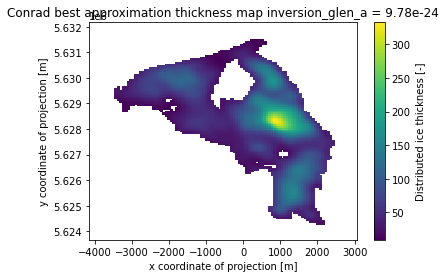

In [9]:
best_model= new_mb_grad_corr_dem(num, dem, glacier, parameter_name, Creep_best, True, True)
mean_thick=np.mean(best_model.distributed_thickness) #[best_model[0]>0])
# mfl_thick=best_model[1]

best_model.distributed_thickness.plot()
plt.title(glacier[num]+' best approximation thickness map ' + parameter_name + ' = ' +str(Creep_best))
# plt.savefig(products+'dem_corr_best_map_'+ glacier[num]+'.png', dpi=100)

In [1]:
print(mean_thick)
best_model.distributed_thickness.to_netcdf(products + glacier[num] + '_optimized_new.nc')

NameError: name 'mean_thick' is not defined

In [ ]:
# NO_DEM=optimize(parameter_name,Creep_val,obs_data, Cal, Val, glacier, num) ### must set dem corr to False
# NO_DEM

In [ ]:
# DEF_MB=optimize(parameter_name,Creep_val,obs_data, Cal, Val, glacier, num) ##must comment out MB grad in main def
# DEF_MB